In [9]:
import pandas as pd

shopify_df = pd.read_csv("../data/shopify_sales_sample.csv")
shopify_df["checkout_time"] = pd.to_datetime(shopify_df["checkout_time"])

shopify_df.head()


,order_id,customer_id,customer_type,checkout_time,product_id,product_name,quantity,unit_price,total_amount,ltv
0,ORD-33136,CUST-0019,new,2025-03-15,102,Wireless Headphones,1,89.99,89.99,300.15
1,ORD-41489,CUST-0087,returning,2025-03-25,101,Bluetooth Speaker,2,49.99,99.98,146.89
2,ORD-64499,CUST-0055,returning,2025-03-04,102,Wireless Headphones,3,89.99,269.97,294.52
3,ORD-59679,CUST-0068,new,2025-03-23,103,Smartwatch,2,129.99,259.98,381.22
4,ORD-49466,CUST-0065,returning,2025-03-21,103,Smartwatch,1,129.99,129.99,417.10


In [10]:
product_sales = shopify_df.groupby("product_name")["total_amount"].sum().sort_values(ascending=False)
product_sales.plot(kind="bar", title="Revenue by Product")
shopify_df["customer_type"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Customer Type Distribution")
daily_sales = shopify_df.groupby("checkout_time")["total_amount"].sum()
daily_sales.plot(title="Daily Revenue Over Time")


<Axes: title={'center': 'Daily Revenue Over Time'}, xlabel='checkout_time', ylabel='count'>

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Aggregate by day
daily_df = shopify_df.groupby("checkout_time")["total_amount"].sum().reset_index()

# Create "day number" as a feature
daily_df["day"] = (daily_df["checkout_time"] - daily_df["checkout_time"].min()).dt.days

# Features and target
X = daily_df[["day"]]
y = daily_df["total_amount"]


In [12]:
model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [13]:
future_days = pd.DataFrame({"day": list(range(X["day"].max() + 1, X["day"].max() + 8))})
future_sales = model.predict(future_days)

# Show predictions
for i, pred in enumerate(future_sales):
    print(f"Day {future_days['day'][i]} → Predicted Revenue: ${pred:.2f}")


Day 31 → Predicted Revenue: $2027.39
Day 32 → Predicted Revenue: $2042.34
Day 33 → Predicted Revenue: $2057.29
Day 34 → Predicted Revenue: $2072.24
Day 35 → Predicted Revenue: $2087.19
Day 36 → Predicted Revenue: $2102.14
Day 37 → Predicted Revenue: $2117.09


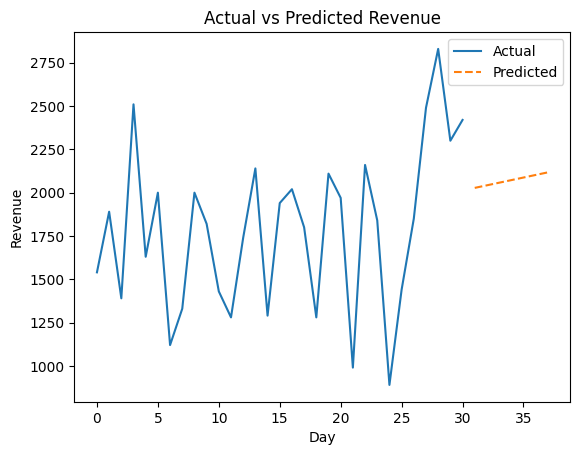

In [14]:
import matplotlib.pyplot as plt

plt.plot(daily_df["day"], y, label="Actual")
plt.plot(future_days["day"], future_sales, label="Predicted", linestyle="--")
plt.legend()
plt.title("Actual vs Predicted Revenue")
plt.xlabel("Day")
plt.ylabel("Revenue")
plt.show()


In [15]:
shopify_recommendations = []

# Best-selling product
top_product = product_sales.idxmax()
shopify_recommendations.append(f"📦 Best-selling product: *{top_product}*. Consider boosting ads for this.")

# New vs Returning ratio
new_ratio = (shopify_df['customer_type'] == 'new').mean()
if new_ratio > 0.6:
    shopify_recommendations.append("👶 High percentage of new customers. Try retention campaigns.")
else:
    shopify_recommendations.append("♻️ Strong base of returning customers. Consider loyalty programs.")

# Revenue growth prediction
if future_sales[-1] > y.mean():
    shopify_recommendations.append("📈 Predicted increase in revenue. Prepare for inventory demand.")
else:
    shopify_recommendations.append("📉 Predicted revenue dip. Consider promotional campaigns.")

for rec in shopify_recommendations:
    print(rec)


📦 Best-selling product: *Smartwatch*. Consider boosting ads for this.
♻️ Strong base of returning customers. Consider loyalty programs.
📈 Predicted increase in revenue. Prepare for inventory demand.


In [16]:
# Save future sales as CSV
forecast_df = future_days.copy()
forecast_df["predicted_revenue"] = future_sales
forecast_df.to_csv("../data/shopify_revenue_forecast.csv", index=False)

# Save recommendations
with open("../data/shopify_recommendations.txt", "w") as f:
    for rec in shopify_recommendations:
        f.write(rec + "\n")
